In [1]:
from matplotlib import pyplot as plt
from pyppca import ppca
from sklearn import mixture
from sklearn.cluster import SpectralClustering
from operator import itemgetter
import os
from sklearn.decomposition import PCA
import numpy as np
import pickle
import sys
import pandas as pd
import scanpy as sc
from sklearn.metrics import *
data_folder_path = '../../../../data'
sys.path.append(data_folder_path)
import matplotlib.patches as mpatches
import anndata as ad
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
import gpflow
float_type = gpflow.default_float()
import gpflux
from gpflow.config import default_float
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import muon as mu
from muon import atac as ac
from muon import prot as pt
sys.path.append('../../../../mogp_decomposition/')
import mwgp as mwgp
from mwgp import GPD
import glob
from evaluation import *

def get_free_gpu_idx():
    """Get the index of the GPU with current lowest memory usage."""
    os.system("nvidia-smi -q -d Memory |grep -A4 GPU|grep Used >tmp")
    memory_available = [int(x.split()[2]) for x in open("tmp", "r").readlines()]
    return np.argmin(memory_available)

gpu_idx = get_free_gpu_idx()
print("Using GPU #%s" % gpu_idx)
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)

2024-06-18 00:39:53.535613: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 00:39:53.748699: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 00:39:53.801529: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-18 00:39:57.113677: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Using GPU #0
Using GPU #0


## 1. Preparing Dataset

## 2. Loading Dataset

In [2]:
file_path = os.path.join(data_folder_path, 'CITEseq', 'pbmc5k_citeseq.h5mu')
mdata = mu.read(file_path)
mu.pp.intersect_obs(mdata)
rna = mdata.mod['rna']
rna = rna[:,rna.var.highly_variable]
prot = mdata.mod['prot']

#col_dict1 = {i:j for i,j in zip([list(set(rna.obs["celltype"]))[i] for i in range(0, len(set(rna.obs["celltype"])))],  rna.uns["celltype_colors"])}
#col_dict1[None] = '#CDC9C9'
col_dict1 = {'CD14 mono': '#8000ff',
                 'memory-like NK': '#5641fd',
                 'CD8+ naïve T': '#2c7ef7',
                 'pDC': '#00b5eb',
                 'CD16 mono': '#2adddd',
                 'intermediate mono': '#54f6cb',
                 'CD4+ naïve T': '#80ffb4',
                 'mature B': '#abf69b',
                 'CD4+ memory T': '#d4dd80',
                 'NK': '#ffb360',
                 'CD8+ memory T': '#ff7e41',
                 'pre-B': '#ff4121',
                 'Treg': '#ff0000',
                 None: '#CDC9C9'}
    
cell_type_list1=['CD4+ naïve T','CD4+ memory T','intermediate mono','CD8+ memory T','CD14 mono',
                   'NK','intermediate mono','mature B','pre-B','memory-like NK','intermediate mono', 
                   'CD16 mono','Treg','CD8+ naïve T','pDC']
cell_type_list_modified1=cell_type_list1
rank_genes_groups=rna.uns["rank_genes_groups"]["names"]

cell_type_list2=['CD4+ naïve T', 'CD4+ memory T', 'Treg','CD8+ naïve T','CD8+ memory T','NK','memory-like NK',
               'pre-B','mature B', 'CD14 mono','intermediate mono','CD16 mono','pDC']
rank_prots_groups=prot.uns["rank_genes_groups"]["names"]
cell_type_list_modified2=['CD4+ naïve T', 'CD4+ memory T', 'Treg','CD8+ naïve T','CD8+ memory T','NK','memory-like NK',
                 'pre-B','mature B', 'CD14 mono','intermediate mono','CD16 mono','pDC']
        

In [3]:
rna

View of AnnData object with n_obs × n_vars = 3891 × 1734
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
prot

AnnData object with n_obs × n_vars = 3891 × 32
    obs: 'celltype'
    var: 'gene_ids', 'feature_types', 'highly_variable'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## 3. Defining the model

## 4. Evaluation

#### num_epochs = 200
#### batch_size = 10000

In [6]:
dim1 = 2
dim2 = 2
dim3 = 2
num_epochs = 200
n_inducing_points1 = 512
n_inducing_points2 = 512
batch_size = 10000
with_PCA = 0
with_PPCA = 0
scale_emb1 = 0
scale_emb2 = 0
emb_reg = 0.001
lr = float(0.01)
kernel = ["RBF"]


400
100


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


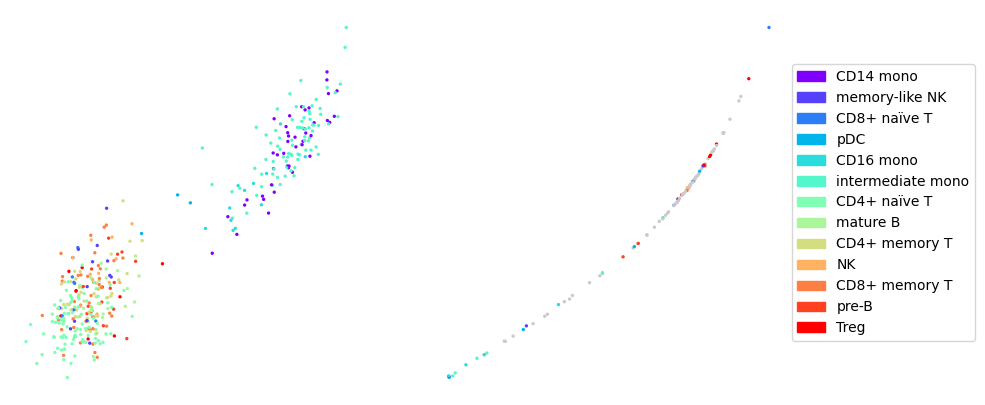

400
200


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


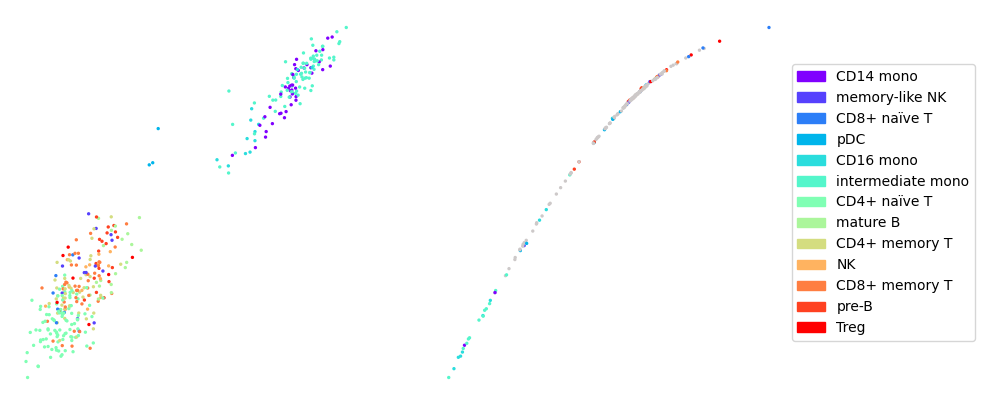

400
400


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


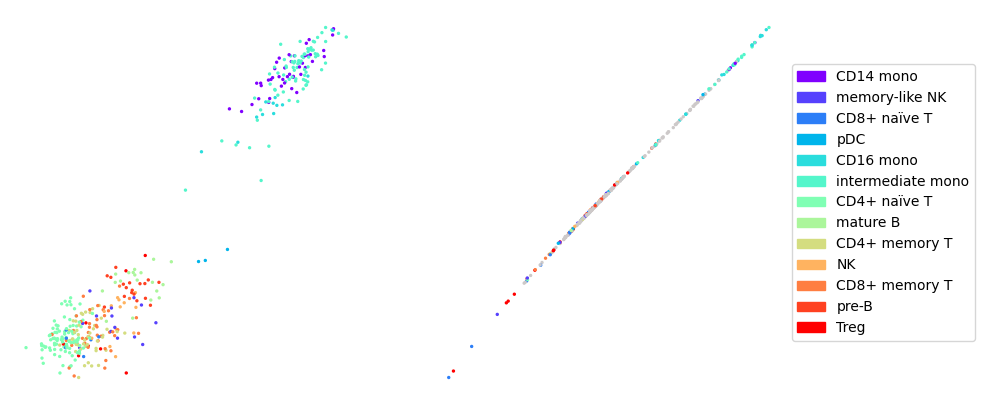

400
600


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


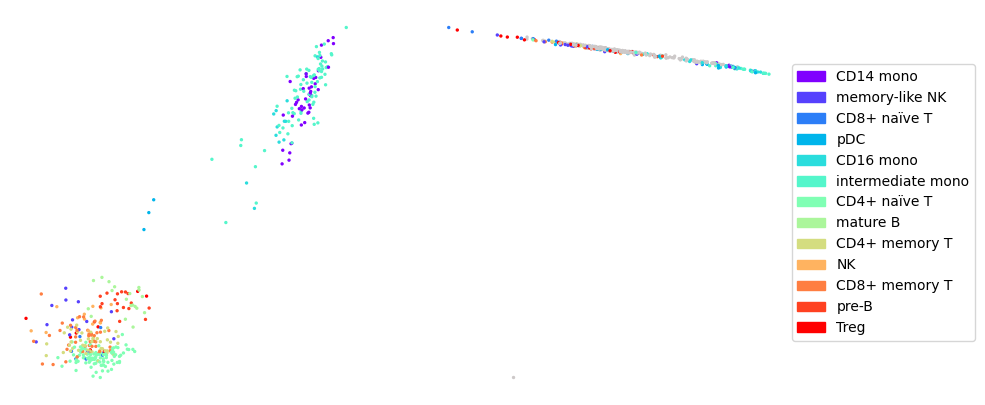

400
800


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


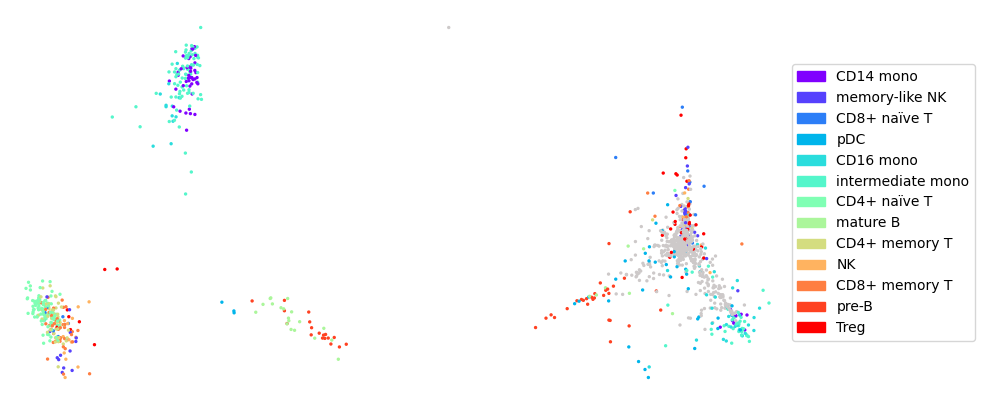

400
1000


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


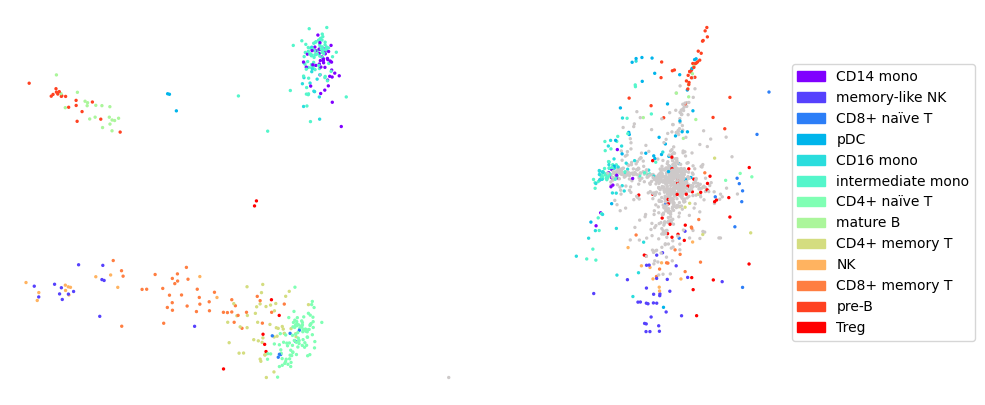

400
1200


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


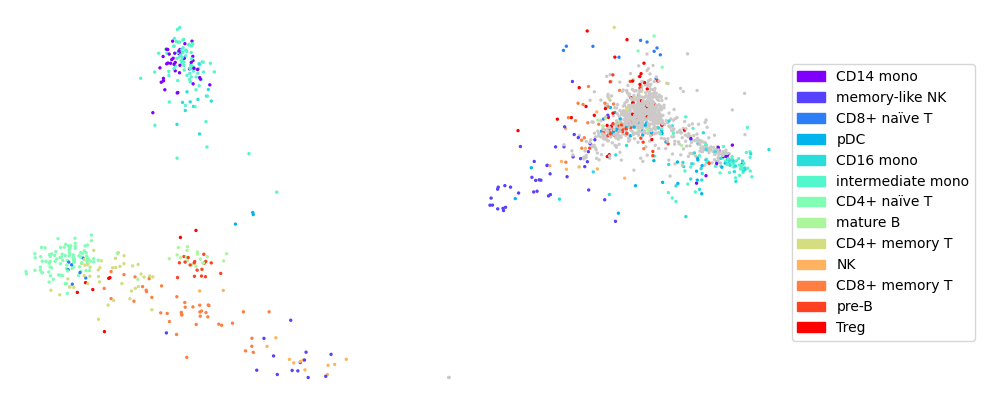

400
1500


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


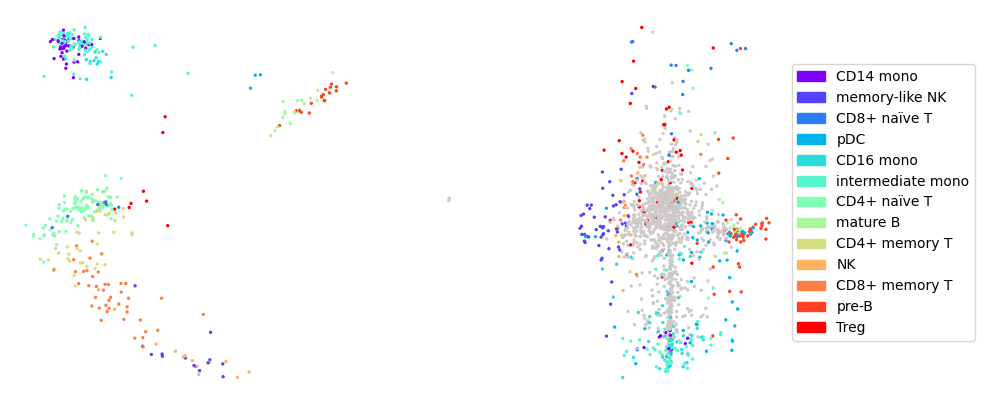

400
1734


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


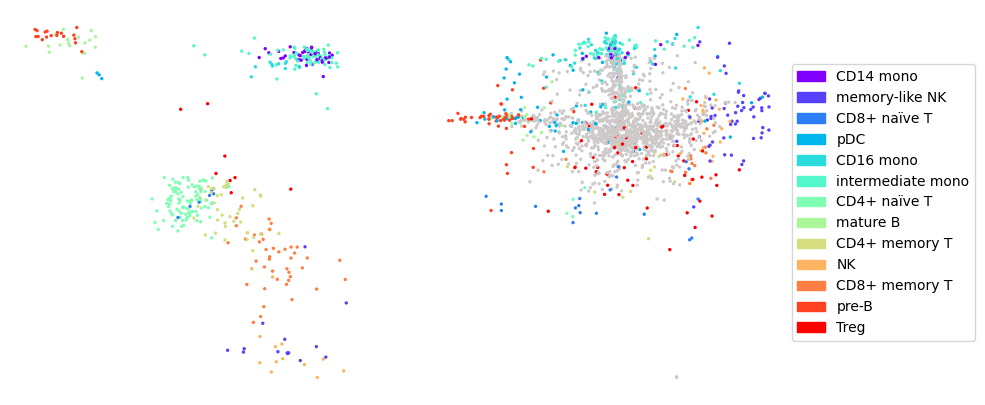

800
100


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


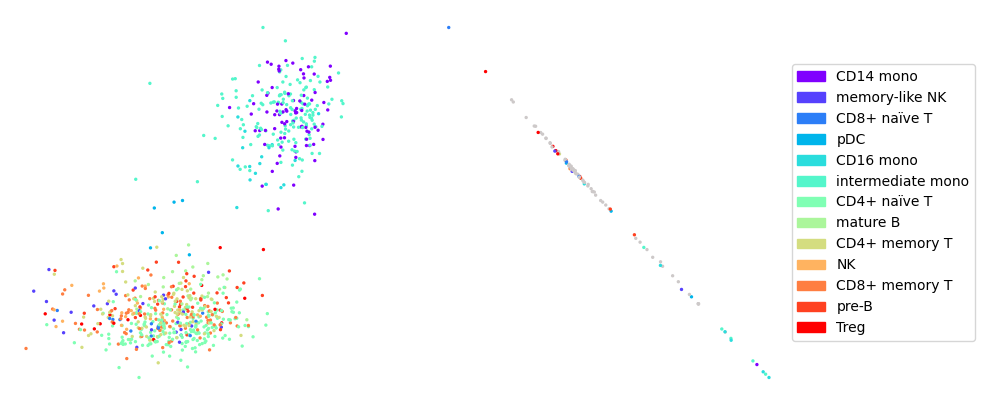

800
200


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


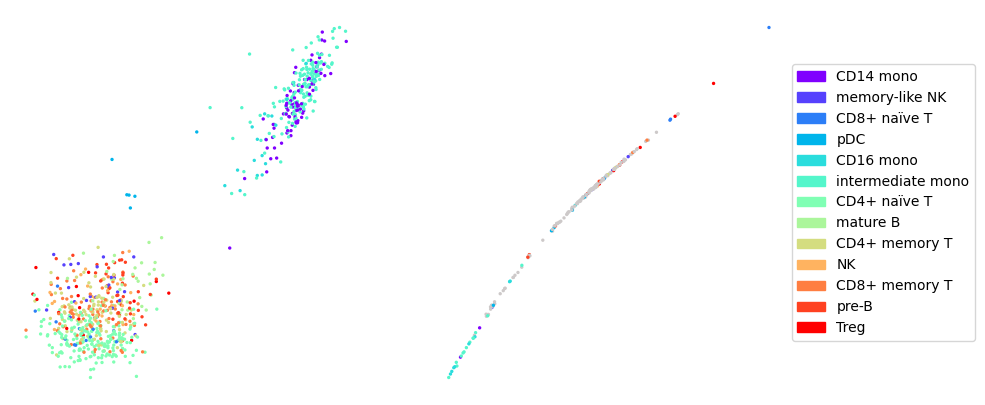

800
400


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


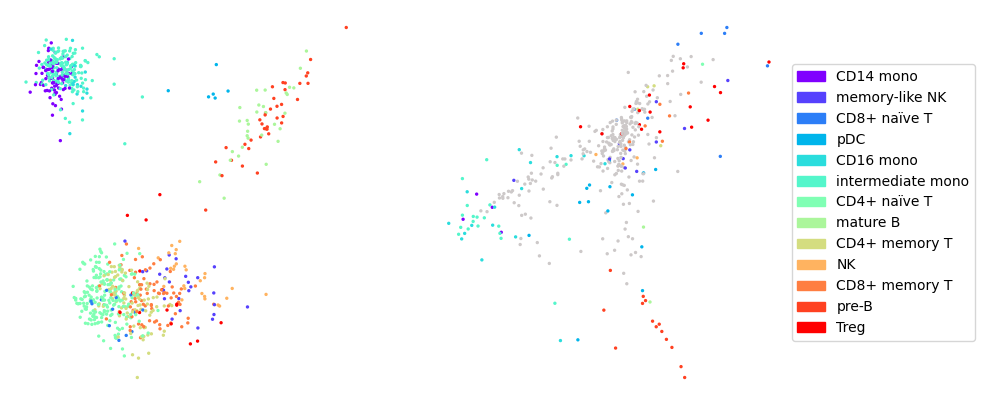

800
600


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


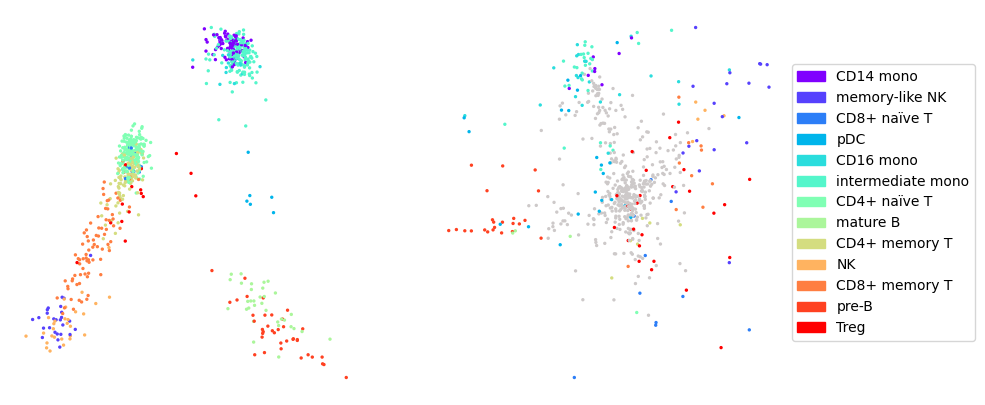

800
800


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


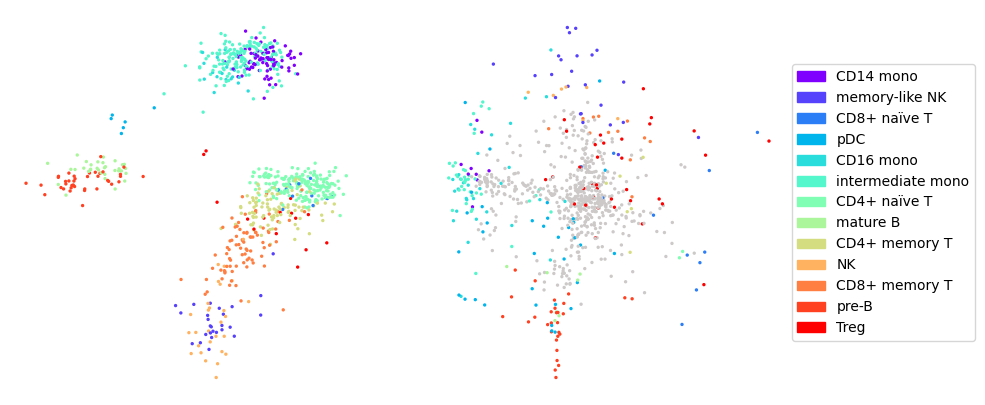

800
1000


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


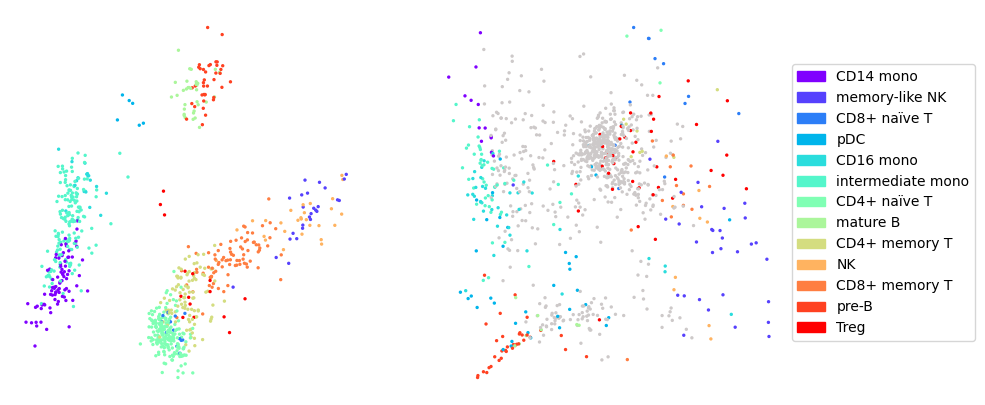

800
1200


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


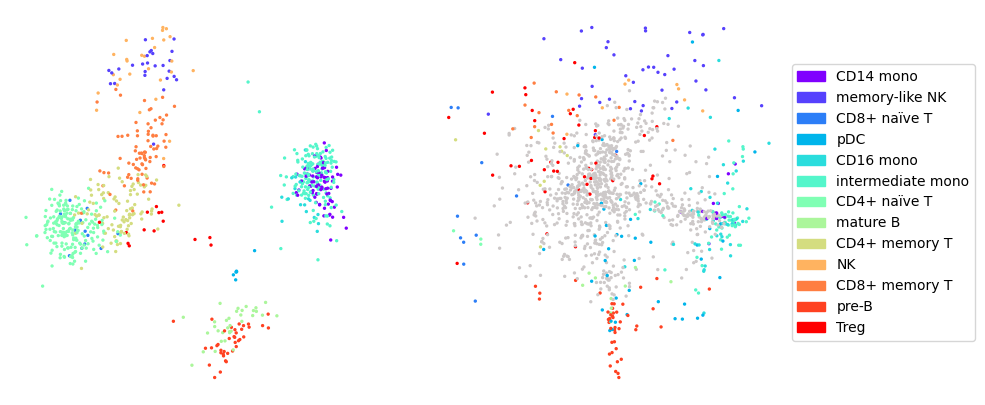

800
1500


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


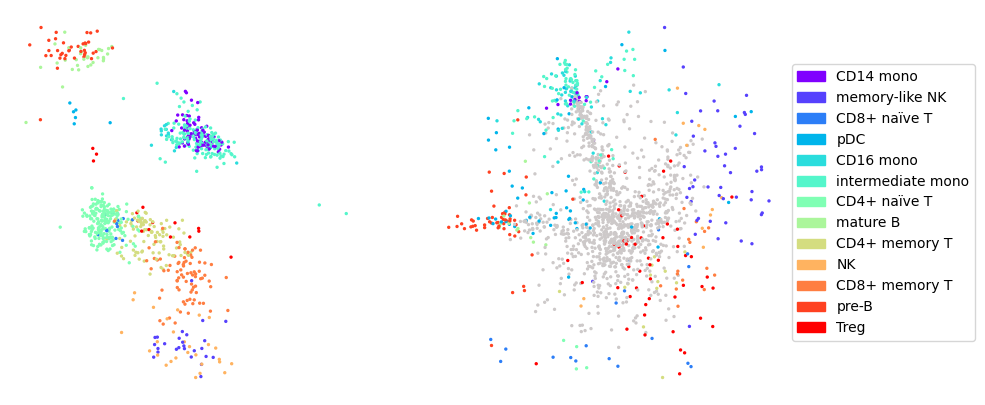

800
1734


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


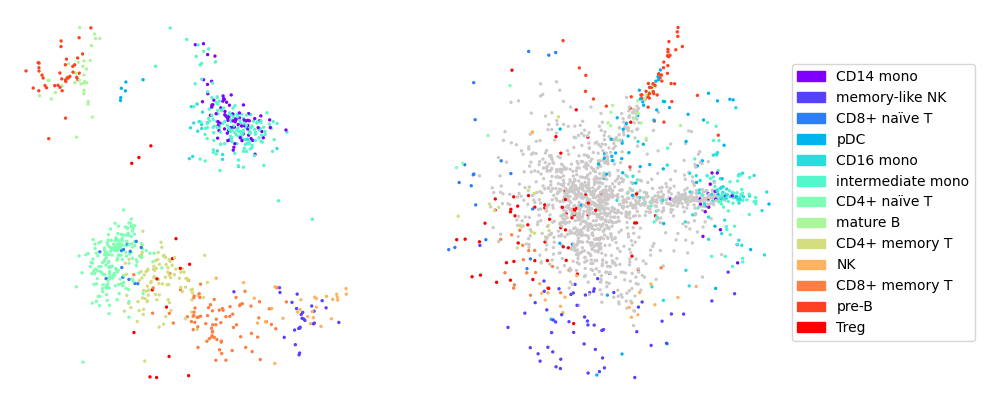

1200
100


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


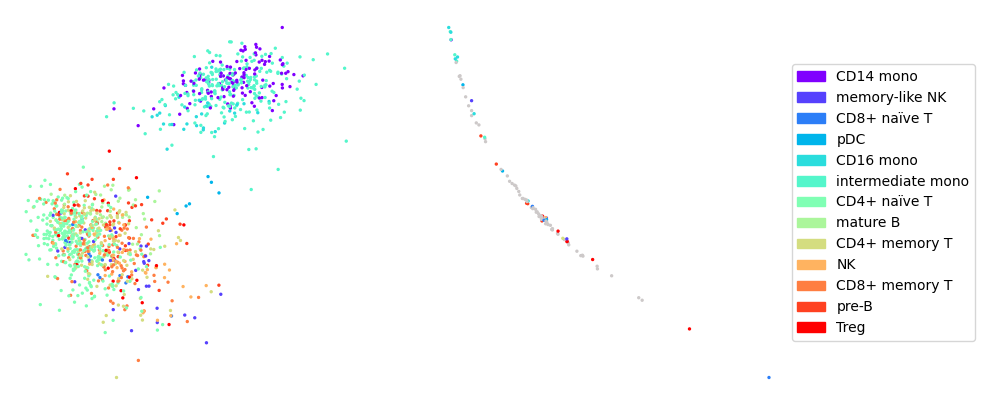

1200
200


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


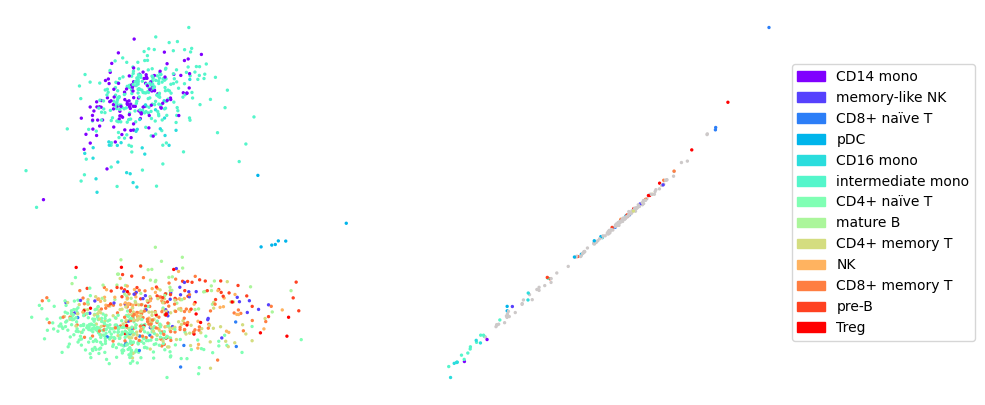

1200
400


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


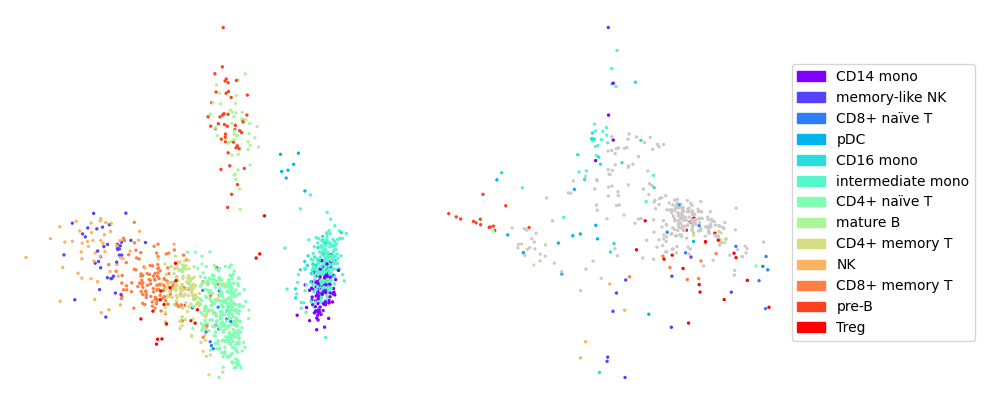

1200
600


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


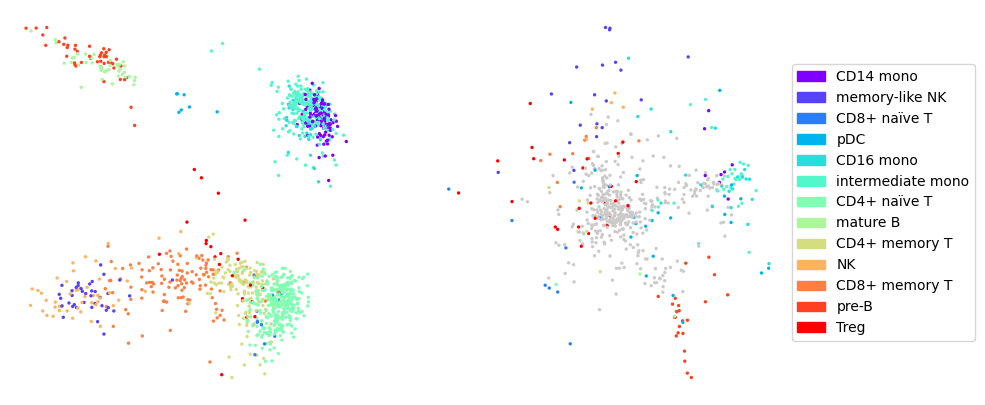

1200
800


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


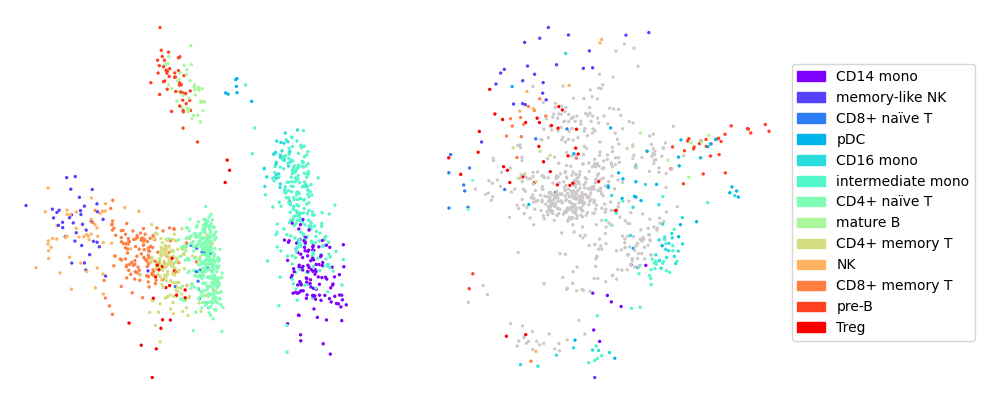

1200
1000


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


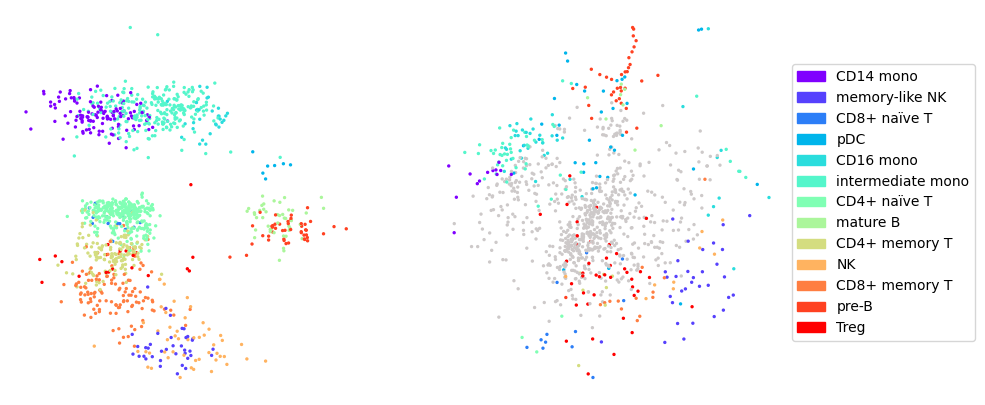

1200
1200


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


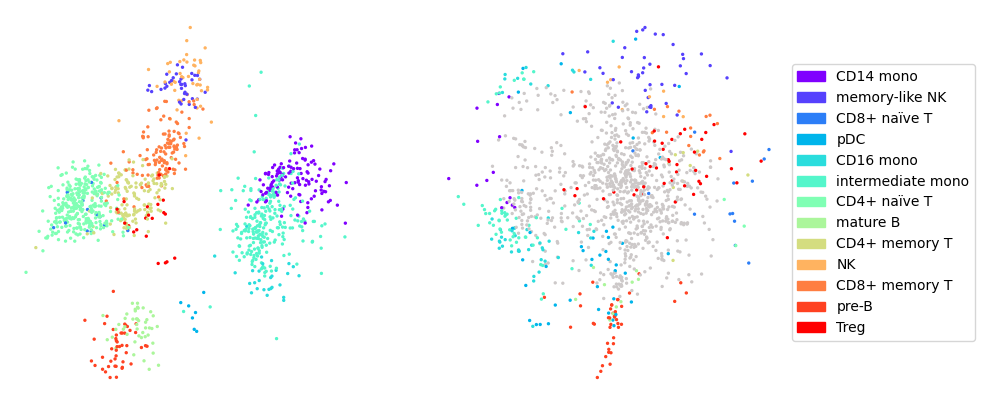

1200
1500


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


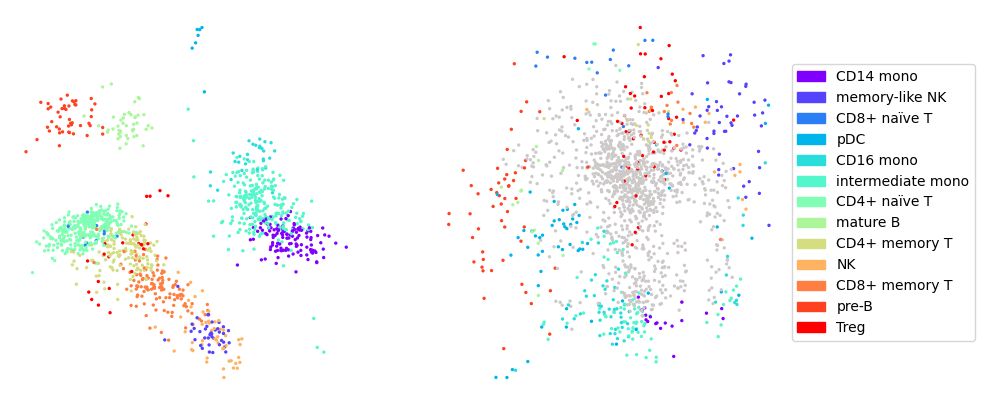

1200
1734


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


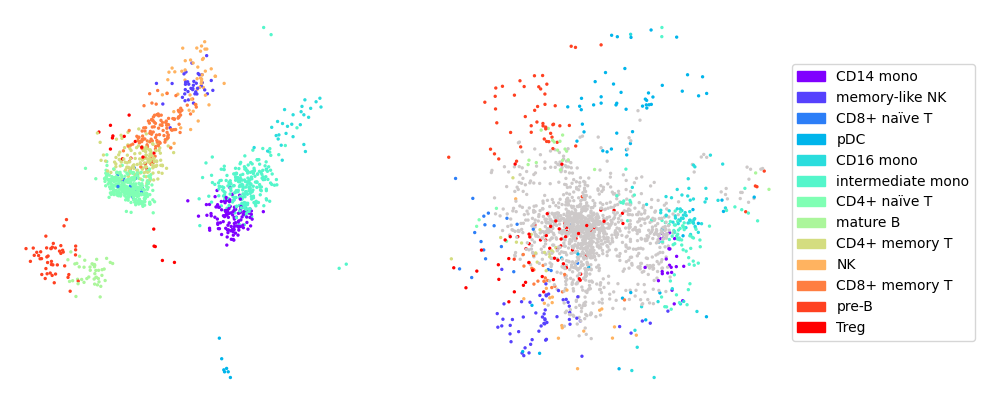

1800
100


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


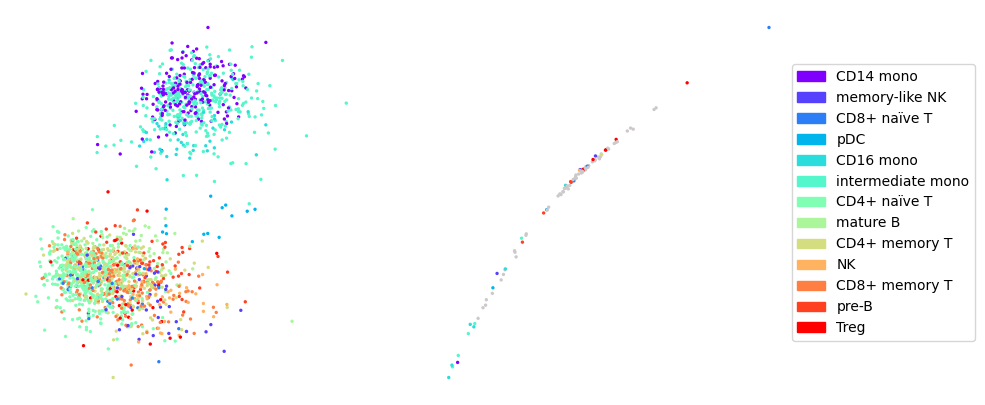

1800
200


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


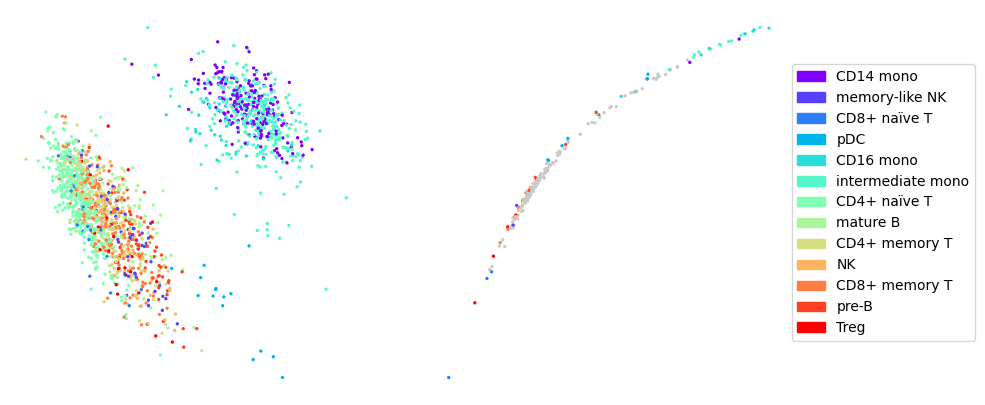

1800
400


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


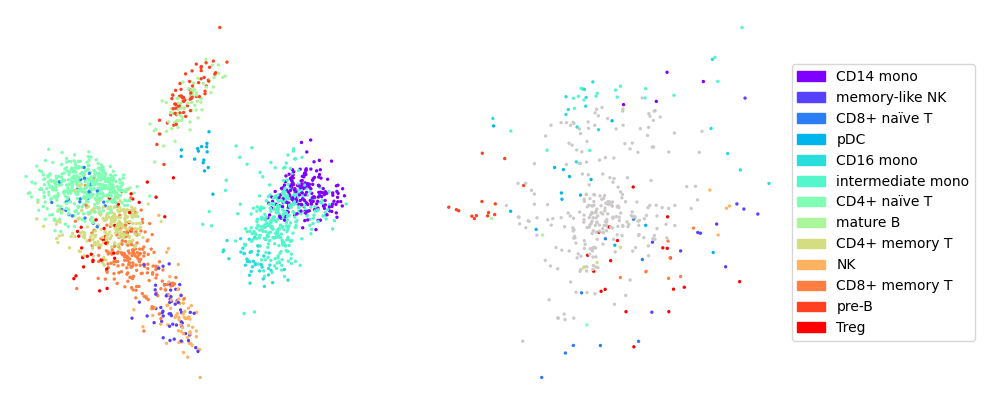

1800
600


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


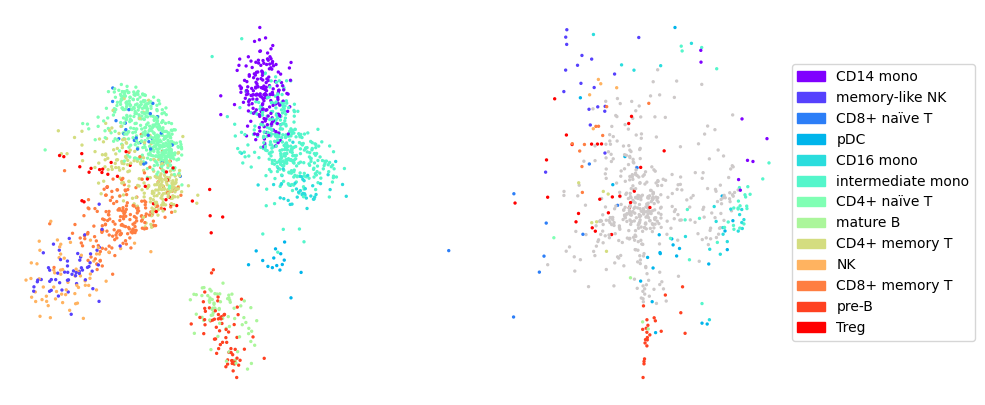

1800
800


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


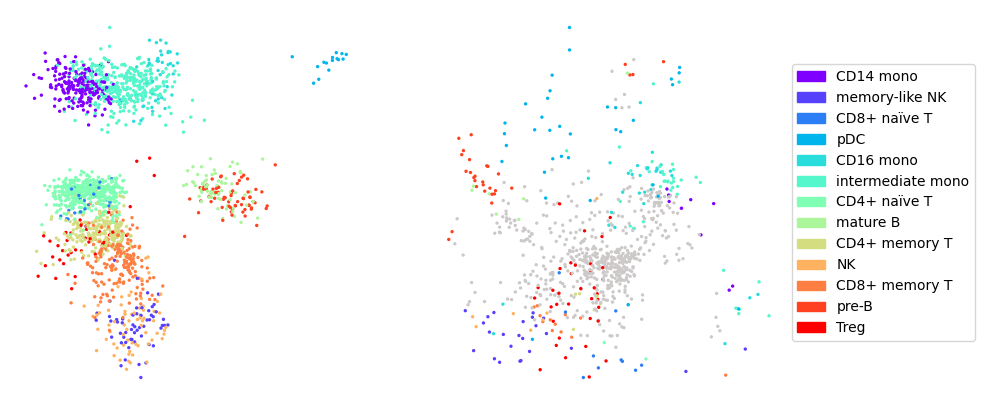

1800
1000


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


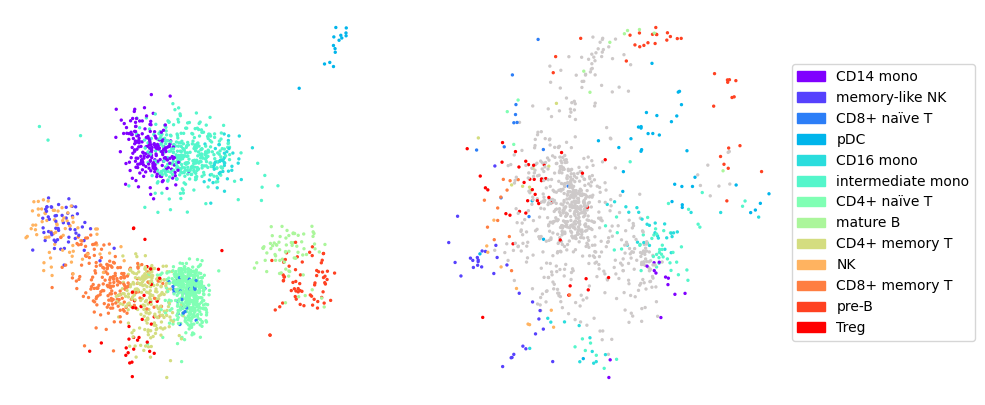

1800
1200


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


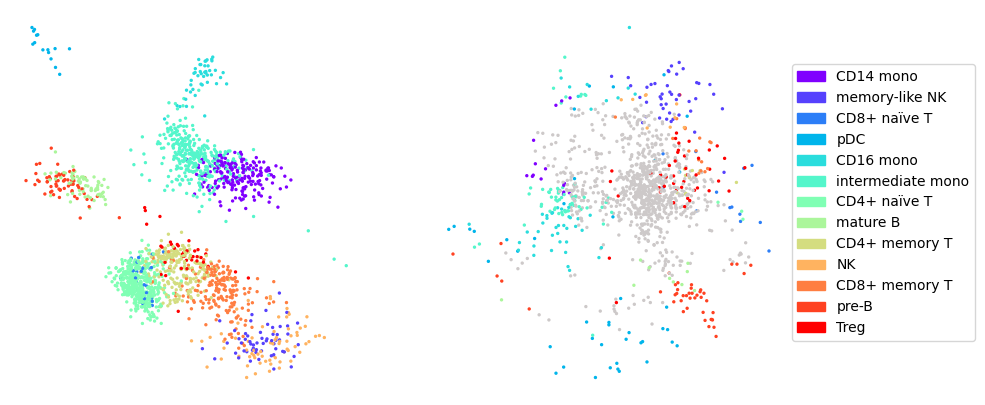

1800
1500


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


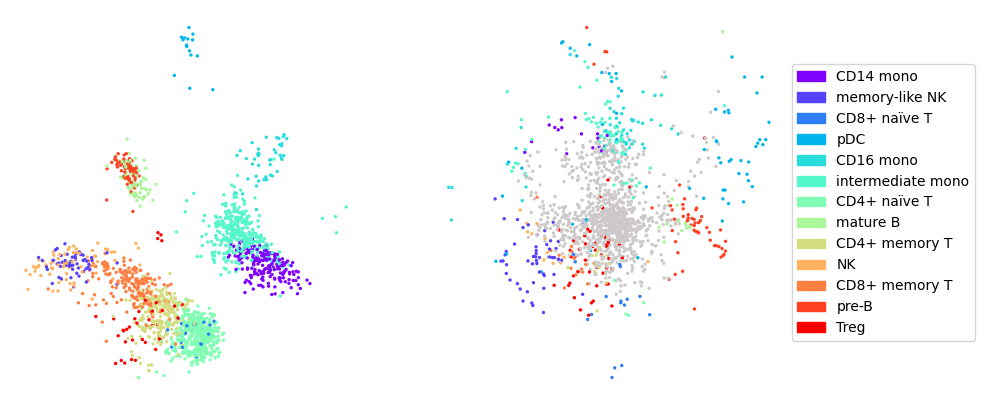

1800
1734


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


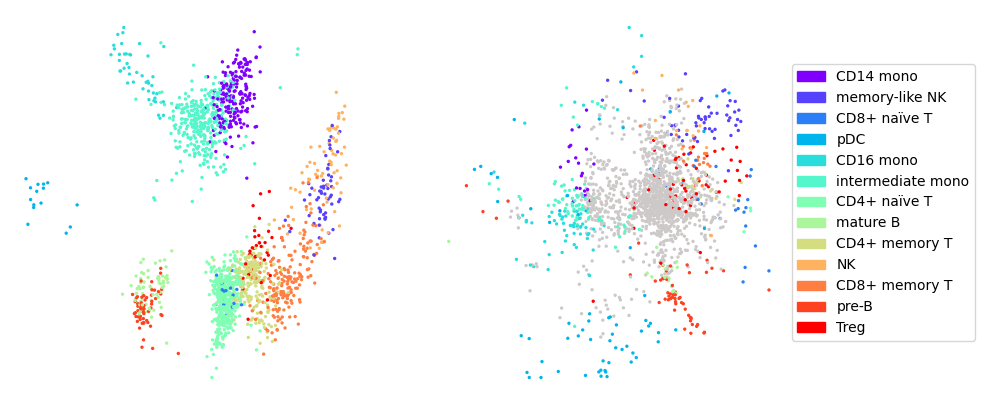

2200
100


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


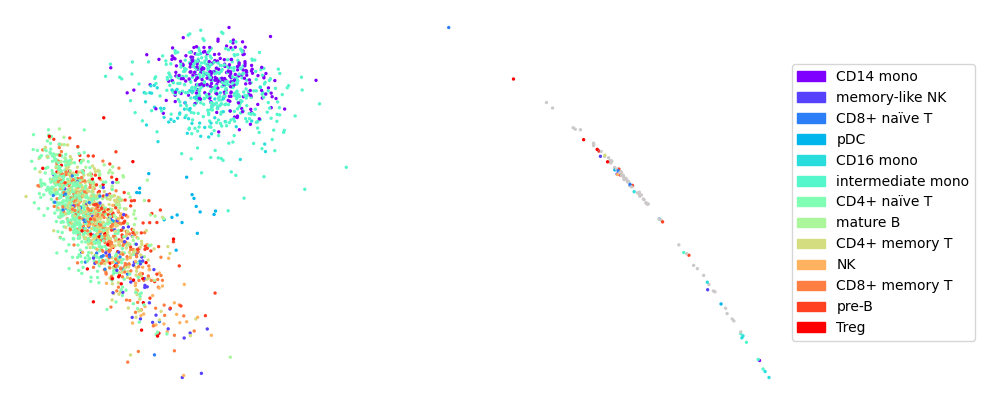

2200
200


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


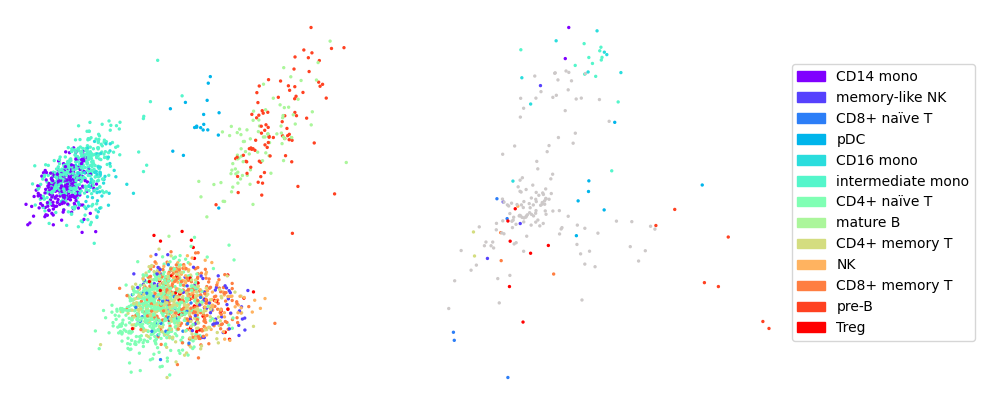

2200
400


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


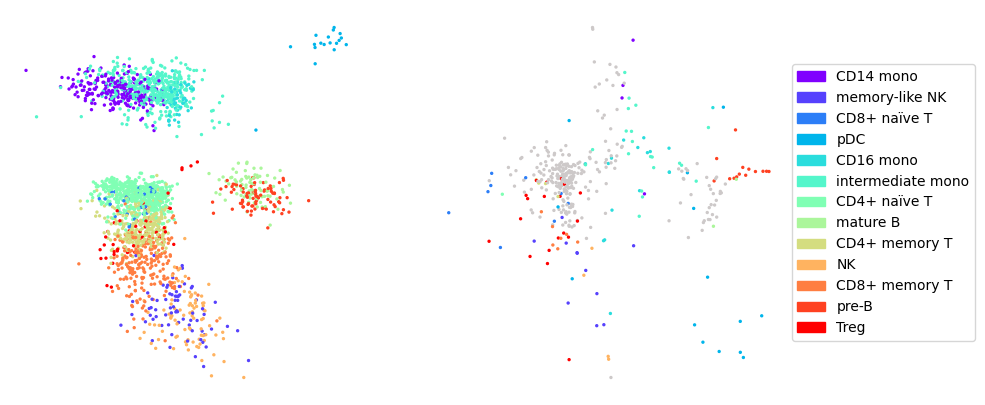

2200
600


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


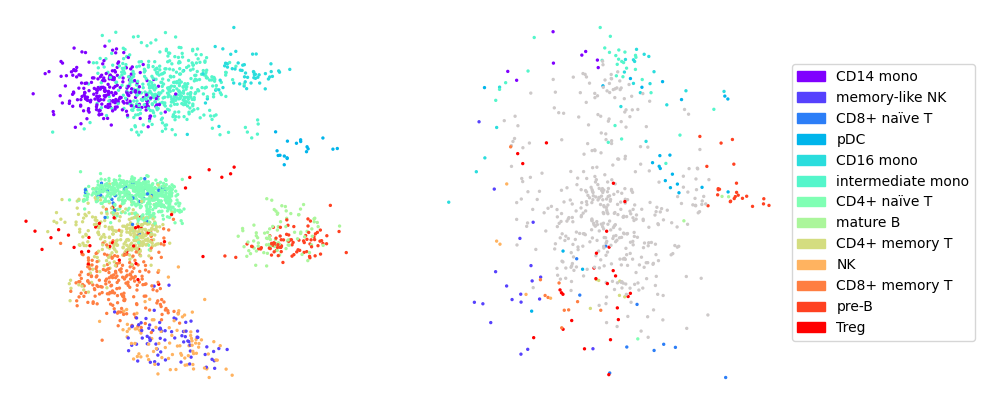

2200
800


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


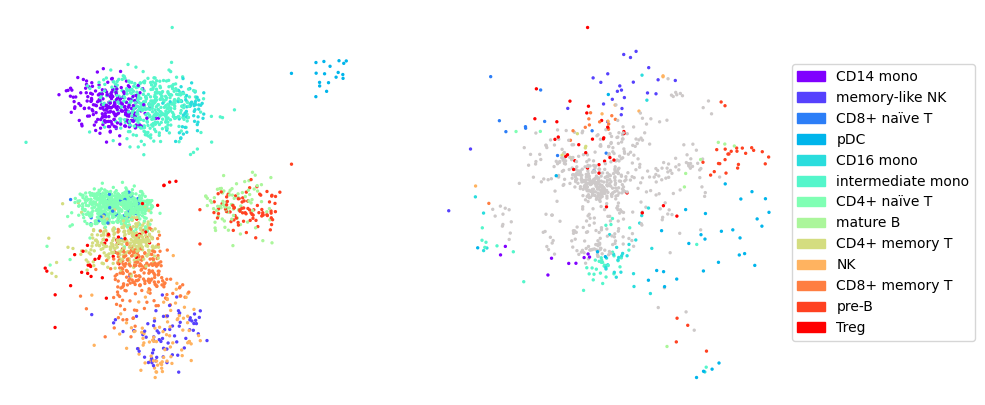

2200
1000


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


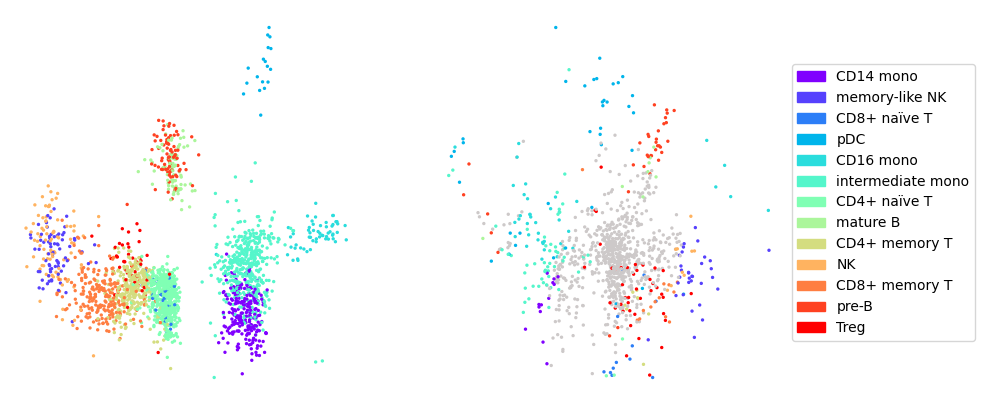

2200
1200


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


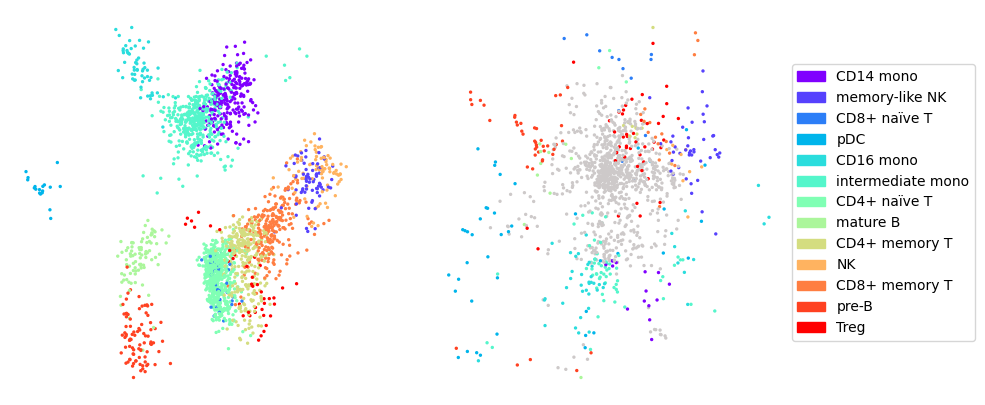

2200
1500


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


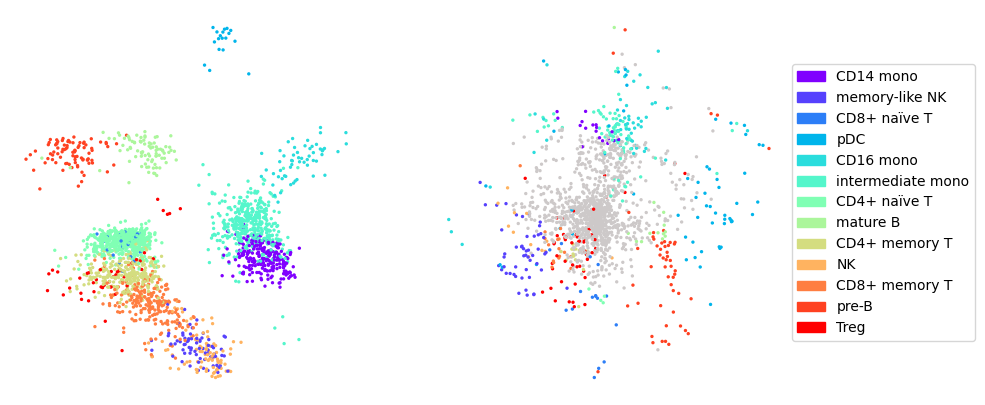

2200
1734


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


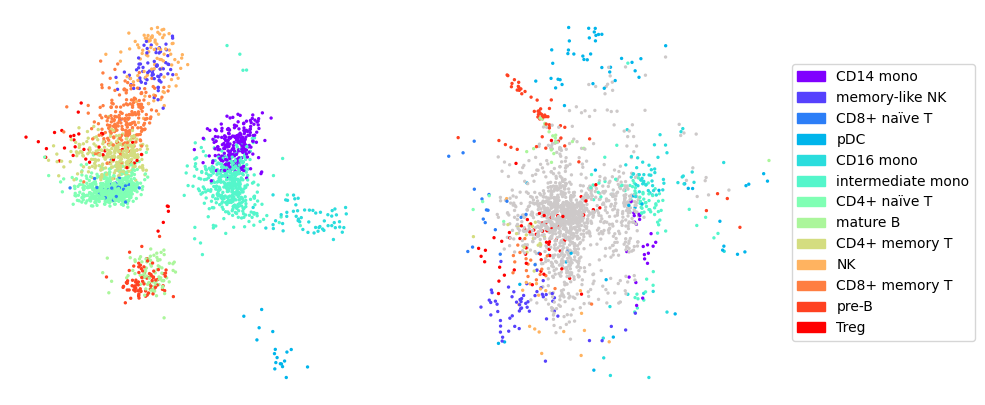

2600
100


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


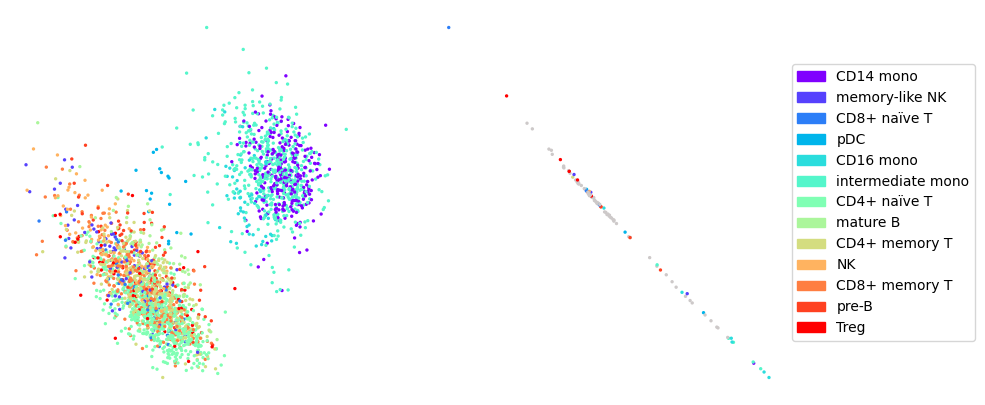

2600
200


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


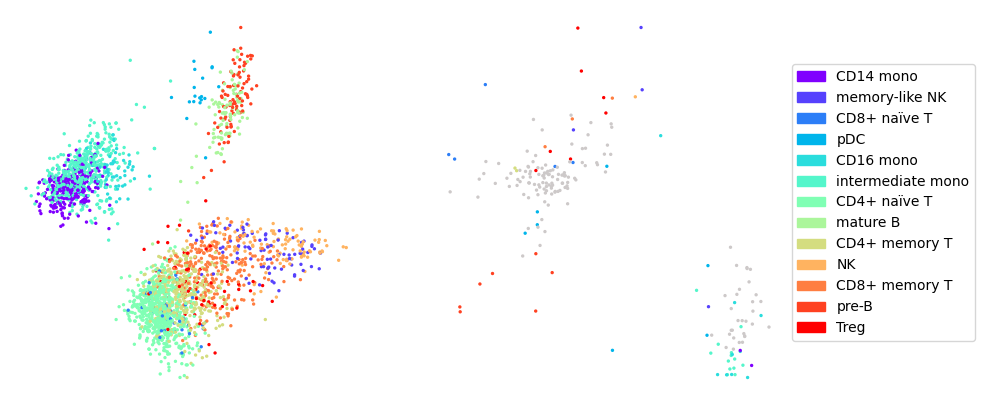

2600
400


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


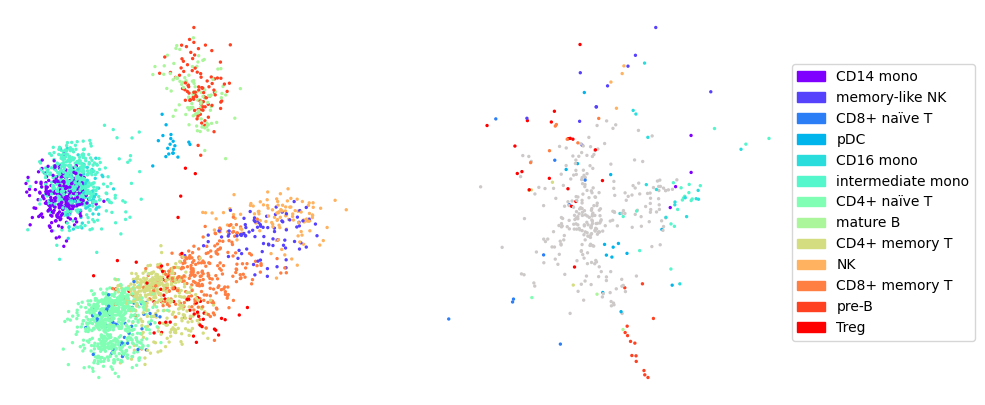

2600
600


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


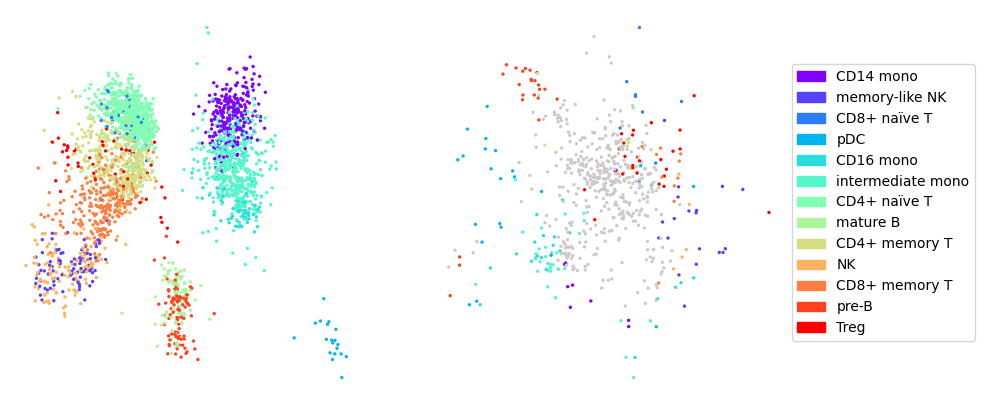

2600
800


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


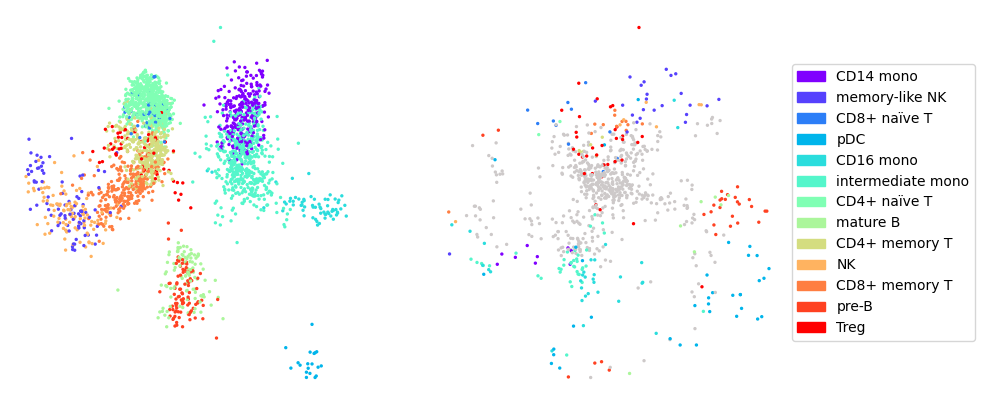

2600
1000


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


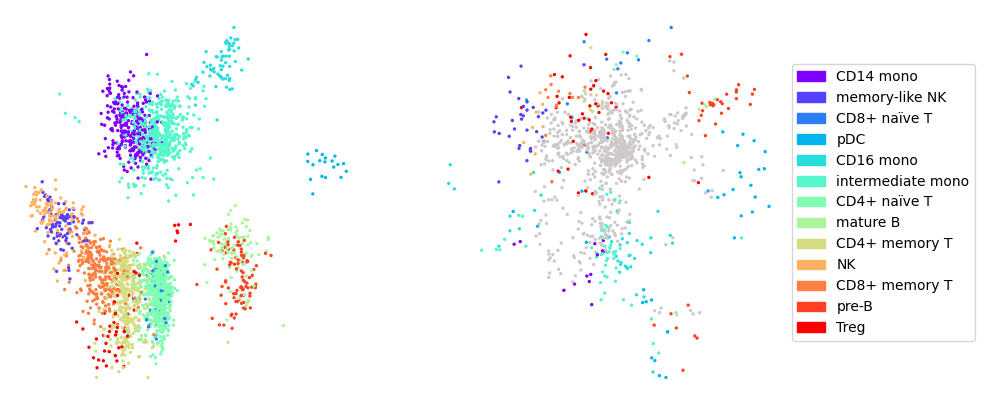

2600
1200


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


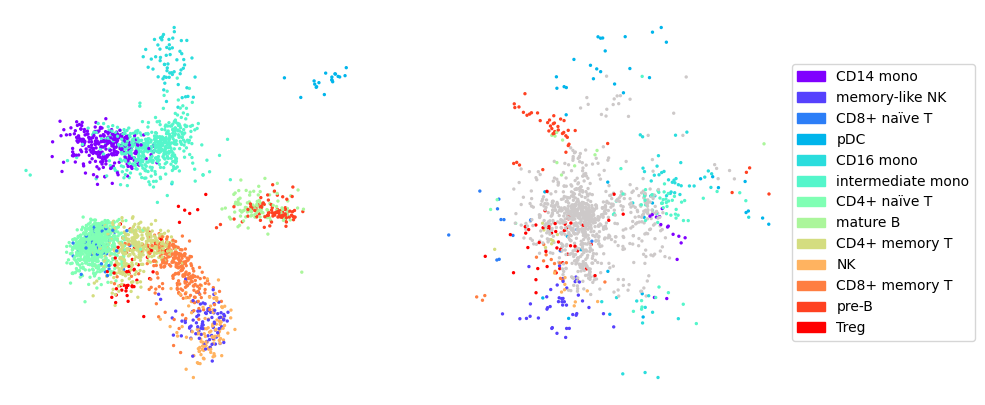

2600
1500


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


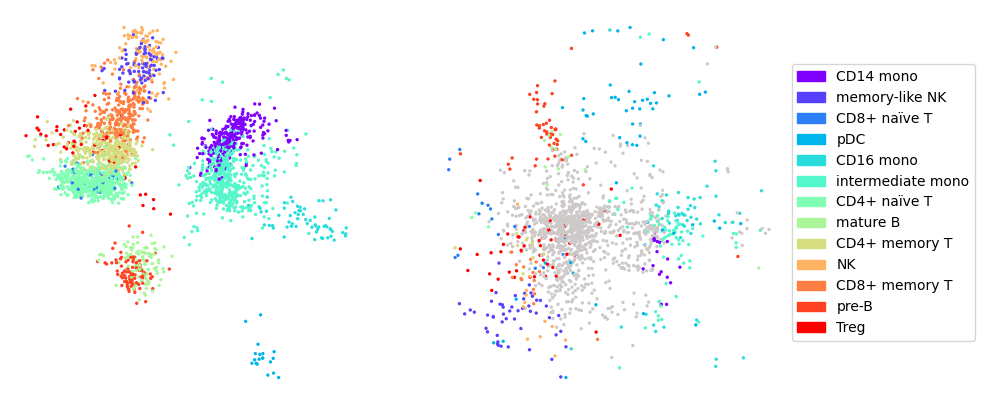

2600
1734


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


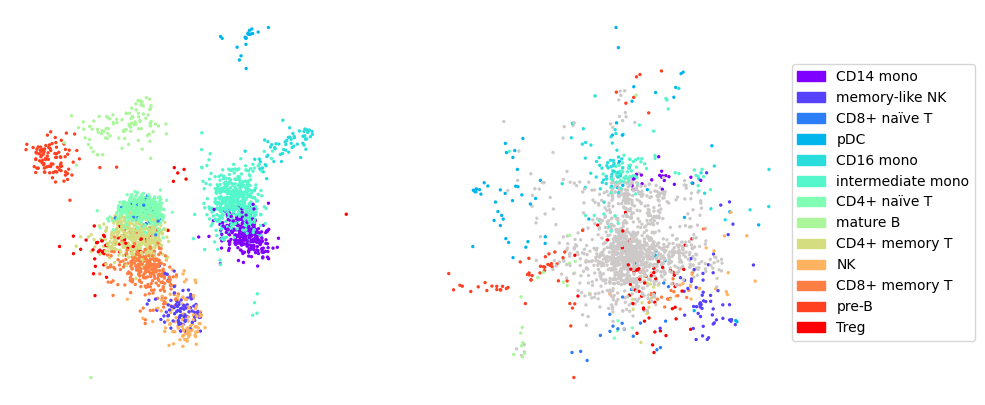

3891
100


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


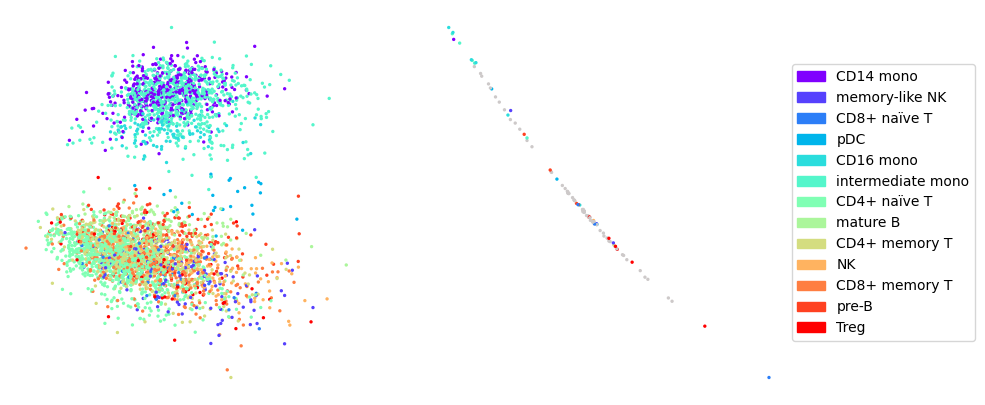

3891
200


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


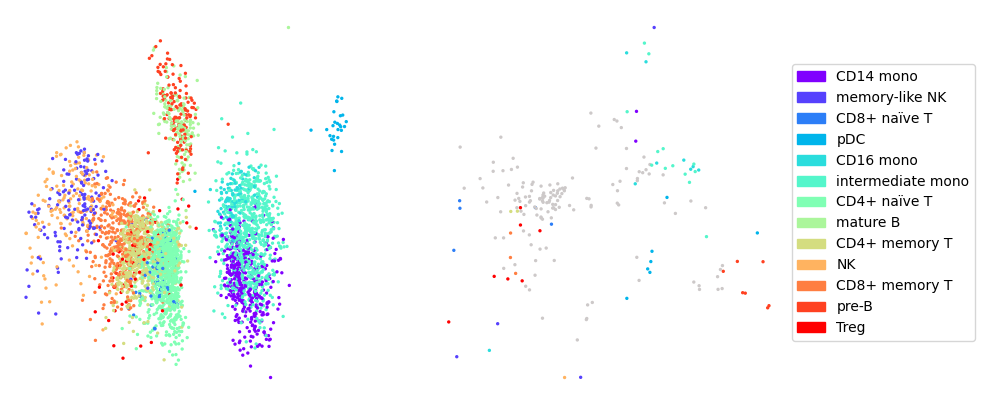

3891
400


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


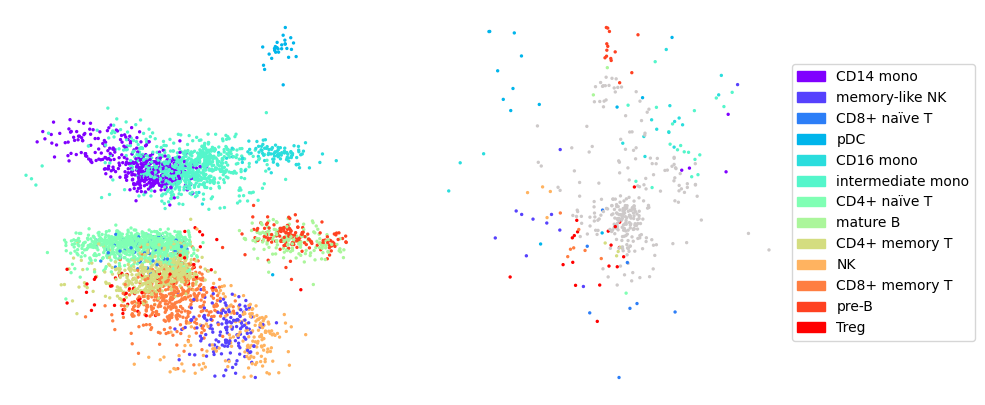

3891
600


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


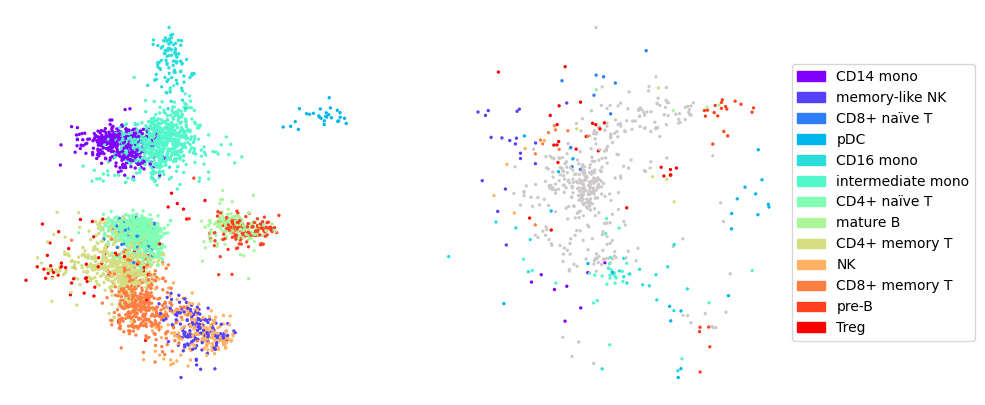

3891
800


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


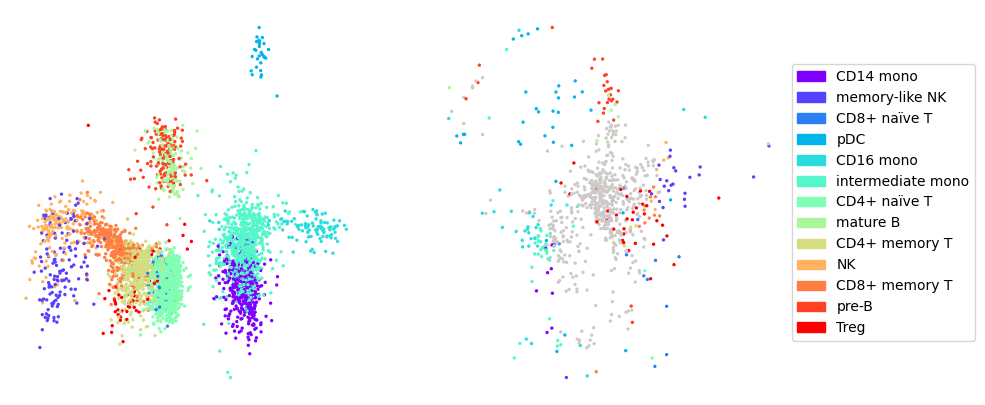

3891
1000


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


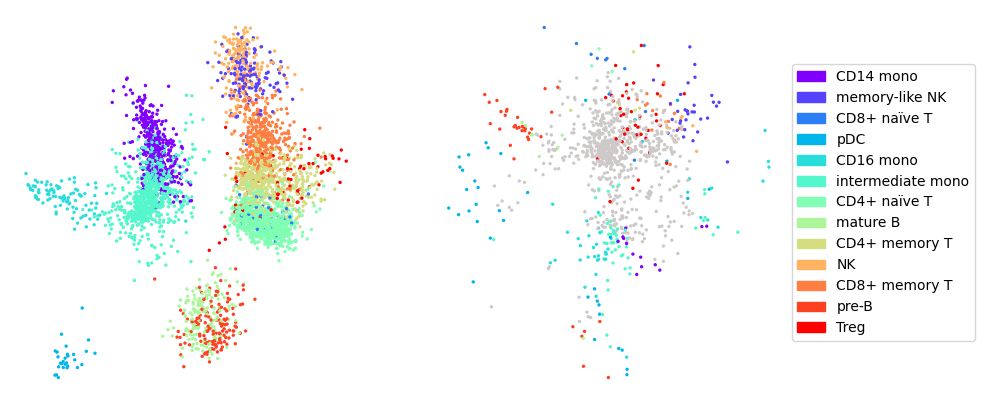

3891
1200


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


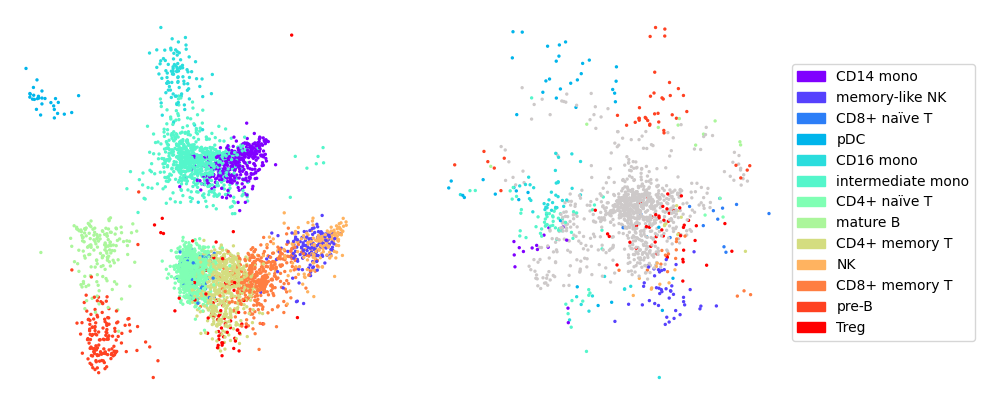

3891
1500


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


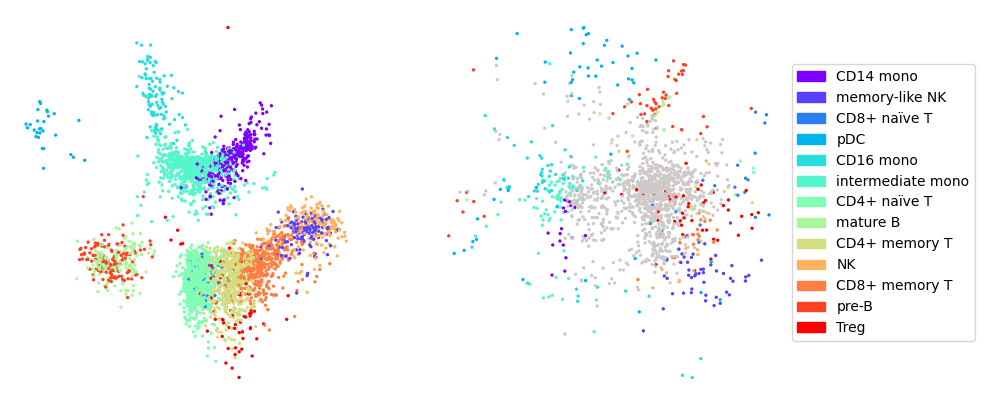

3891
1734


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


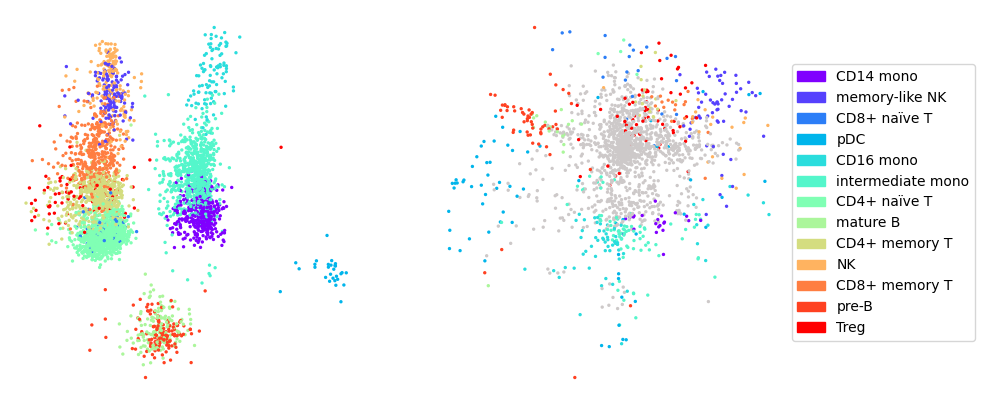

In [47]:
cell_arr=[400, 800, 1200, 1800, 2200, 2600, 3891]
gene_arr=[100, 200, 400, 600, 800, 1000, 1200, 1500, 1734]
for l in range(7):
     for m in range(9):
            cell=cell_arr[l]
            gene=gene_arr[m]
            print(cell)
            print(gene)
            
            file = open('./Results/num_rows'+str(cell)+'num_cols'+str(gene)+'.csv',"rb")
            row_indices = pickle.load(file)
            col_indices = pickle.load(file)
            matrix1 = rna.X[row_indices, :][:,col_indices]
            matrix2 = prot.X[row_indices, :]
            RNA_Normalized_2000 = (matrix1-np.mean(matrix1,0))/np.std(matrix1,0)
            prot_Normalized_2000 = (matrix2-np.mean(matrix2,0))/np.std(matrix2,0)
            [cells,genes] = RNA_Normalized_2000.shape
            np.random.seed(11111986)
            [I,J] = RNA_Normalized_2000.shape
            [I,K] = prot_Normalized_2000.shape
            
            [i,j] = np.nonzero(RNA_Normalized_2000)
            X_tr1 = []
            for cnt in range(len(i)):
                X_tr1.append([i[cnt],j[cnt]])
            X_tr1 = np.asarray(X_tr1)
            Y_tr1 = RNA_Normalized_2000.ravel()
            
            [i,j] = np.nonzero(prot_Normalized_2000)
            X_tr2 = []
            for cnt in range(len(i)):
                X_tr2.append([i[cnt],j[cnt]])
            X_tr2 = np.asarray(X_tr2)
            Y_tr2 = prot_Normalized_2000.ravel()
            if (with_PCA==0 or with_PPCA==0):
                title = 'cells='+str(cell)+' genes='+str(gene)+'  dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+ ' with_PCA='+str(with_PCA)
                save_path = './PBMC5KCITEseqRNA-GPFlux '+title+'/' 
                #save_path='./PBMC5KCITEseq2View-GPFlux  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=500  emb_reg=0.001 with_PCA=0'
                hyper_params = {
                'I':I,
                'J':J,
                'K':None,    # the number of entities in each domain
                'M1': n_inducing_points1,                  # the number of inducing pairs
                'M2': n_inducing_points2,                  # the number of inducing pairs
                'emb_sizes': [dim1,dim2,dim3],      # the embedding sizes
                'batch_size':batch_size,      # the size of training batches
                'obs_mean1': Y_tr1.mean(),  # the mean of target
                'obs_mean2': Y_tr2.mean(),  # the mean of target
                'emb_reg': emb_reg,          # l2 norm on the embeddings
                'lr': lr,                # the learning rate 
                'save_path': save_path,        # path to save the trained models.
                }  
                
                gp_md = GPD(**hyper_params)
                gp_md.build(kernels=kernel)
                gp_md.load_model((X_tr1+1), (X_tr2+1))
                
                emb1 = gp_md.emb1
                embs1 = emb1((X_tr1+1)[0:-1:J,0])
                
                emb2 = gp_md.emb2
                embs2 = emb2((X_tr1+1)[0:J,1])
                
                RNA_struct_MOGP = ad.AnnData(embs1.numpy())
                RNA_struct_MOGP.obsm['X_tsne']= embs1.numpy()
                
                Genes_struct_MOGP = ad.AnnData(embs2.numpy())
                Genes_struct_MOGP.obsm['X_tsne']= embs2.numpy()
                
                #tmp=rna.obs["celltype"][row_indices]
                #fig = plt.figure(figsize=(15,5))
                #ax1 = fig.add_subplot(111)
                #ax1.scatter(RNA_struct_MOGP.obsm["X_tsne"][:, 0], RNA_struct_MOGP.obsm["X_tsne"][:, 1], s=2, c=[col_dict1[i] for i in tmp]) #c='black')
                #plt.show()
                rna_struct = ad.AnnData(rna.X[row_indices,:][:,col_indices])
                rna_struct.var_names=rna.var_names.values[col_indices]
                rna_struct.obs_names=rna.obs_names.values[row_indices]
                rna_struct.obs["celltype"]=rna.obs["celltype"][row_indices]
                rna_struct.uns["rank_genes_groups"]=rna.uns["rank_genes_groups"]
                Relating_clusters_of_emb1_to_clusters_of_emb2_CITEseq(rna_struct, prot, RNA_struct_MOGP, Genes_struct_MOGP, Prot_struct_MOGP=None,col_dict1=col_dict1, cell_type_list_modified1=cell_type_list_modified1, cell_type_list_modified2=cell_type_list_modified2, n_cell_types=len(list(set(rna.obs["celltype"]))),n_marker_genes=100, use_umap=False)
                                

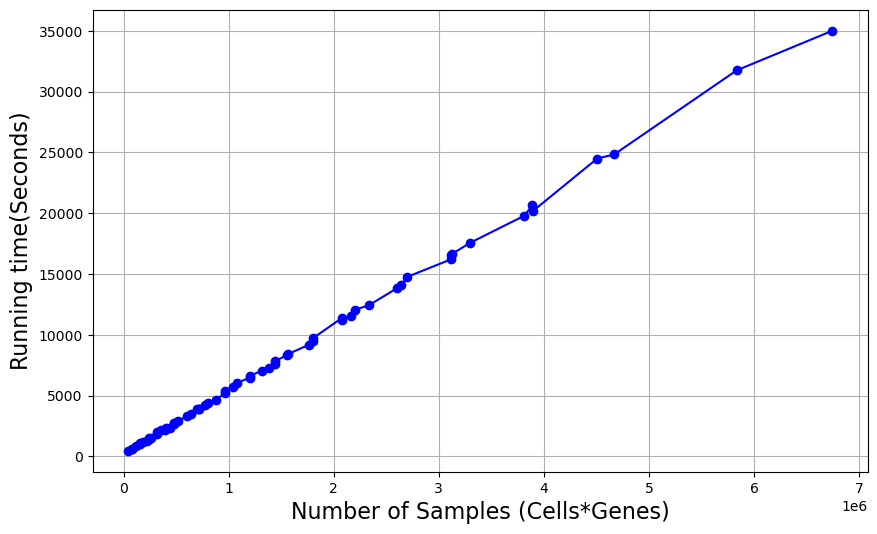

In [15]:
file_path = 'runtime'+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'.log'
#file_path = 'LOG_FILE'
# Initialize lists for results
odd_line_numbers = []
even_line_numbers = []

# Open the log file and read it line by line
with open(file_path, 'r') as file:
    for line_number, line in enumerate(file, start=1):
        # Split the line into words (strings)
        words = line.split()

        if line_number % 2 == 1:  # Odd line numbers
            if len(words) >= 10:
                try:
                    # Get the 9th and 10th strings
                    num1 = float(words[8])
                    num2 = float(words[9])
                    # Multiply the numbers and store the result
                    result = num1 * num2
                    odd_line_numbers.append(result)
                except ValueError:
                    print(f"Line {line_number}: Cannot convert to float.")
            else:
                print(f"Line {line_number}: Not enough words.")
        else:  # Even line numbers
            if len(words) >= 2:
                even_line_numbers.append(words[1])
            else:
                print(f"Line {line_number}: Not enough words.")

# Ensure even_line_numbers has the same length as odd_line_numbers
if len(even_line_numbers) > len(odd_line_numbers):
    even_line_numbers = even_line_numbers[:len(odd_line_numbers)]
elif len(even_line_numbers) < len(odd_line_numbers):
    odd_line_numbers = odd_line_numbers[:len(even_line_numbers)]

# Convert even_line_numbers to float
even_line_numbers = [float(num) for num in even_line_numbers]

# Combine the lists and sort them based on odd_line_numbers
combined_list = sorted(zip(odd_line_numbers, even_line_numbers))

# Separate the sorted values
sorted_odd_line_numbers, sorted_even_line_numbers = zip(*combined_list)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sorted_odd_line_numbers, sorted_even_line_numbers, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Samples (Cells*Genes)',fontsize=16)
plt.ylabel('Running time(Seconds)',fontsize=16)
#plt.title('Plot of Odd Line Multiplication Results vs. Even Line Second Strings')
plt.grid(True)
plt.savefig('RunningTime.pdf', dpi=300, transparent=True, bbox_inches='tight')
plt.show()


In [12]:
plt.savefig('RunningTime.pdf')

<Figure size 640x480 with 0 Axes>